<a href="https://colab.research.google.com/github/panka-z/DataScience/blob/master/%2BReceipe_7_4_Predicting_Stock_Price_using_LSTM_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# doing minimum required imports
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [0]:
from google.colab import files
uploaded = files.upload()

Saving BSE-BOM500180.csv to BSE-BOM500180 (1).csv


In [0]:
# load the dataset
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('BSE-BOM500180.csv', index_col='Date', parse_dates=['Date'], date_parser=dateparse).ffill()

In [0]:
# do a little EDA on it
data.shape

(5904, 12)

In [0]:
# the HDFC bank data is from inception 1996 to till date.
# lets look for last 5 years
# do slicing for last 5 years
data = data['2020-01-14' : '2015-01-15']
data.shape

(1234, 12)

In [0]:
#importing required libraries for LSTM Neural Networks
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
%tensorflow_version 1.x magic

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x magic`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
#creating dataframe
data.sort_index(ascending=True, axis=0, inplace=True)

df_close = data['Close']

df_close.head()

Date
2015-01-15     992.60
2015-01-16    1001.50
2015-01-19    1004.50
2015-01-20    1022.20
2015-01-21    1019.85
Name: Close, dtype: float64

In [0]:
dataset = df_close

#creating train and test sets. Like we are putting 1000 rows for Training and balance 234 for validating
train, test = dataset[0:1000], dataset[1000:]

print(train.tail())
print("--------------------")
test.tail()

Date
2019-01-23    2109.75
2019-01-24    2101.90
2019-01-25    2093.95
2019-01-28    2083.55
2019-01-29    2058.10
Name: Close, dtype: float64
--------------------


Date
2020-01-08    1257.05
2020-01-09    1270.80
2020-01-10    1283.20
2020-01-13    1287.25
2020-01-14    1289.45
Name: Close, dtype: float64

In [0]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(dataset).reshape(-1,1))

x_train, y_train = [], []

for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

print(x_train.shape) # so we have 940 matrices of 60 rows by 1 column
print("---------------------------")
print(y_train.shape)
print("---------------------------")
print(y_train[:5]) # Interpret like this : for every 60 values in x_train , 
                   # we are assuming the 61th value to be an outcome
                   # as our trainSet had 1000 values hence first 60 values derive 61st value, so on , so forth
                   # Hence we would 1000-60 = 940 values.

(940, 60, 1)
---------------------------
(940,)
---------------------------
[0.05324201 0.04665137 0.03905922 0.03631312 0.04409912]


In [0]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 234 values, using past 60 from the train data
inputs = dataset[len(dataset) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

closing_price = np.array([])

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/1
 - 71s - loss: 0.0022


In [0]:
print(closing_price.shape)

(234, 1)


In [0]:
print(test.shape)

(234,)


In [0]:
rms=np.sqrt(np.mean(np.power((np.array(test).reshape(-1,1)-closing_price),2)))
rms

144.35453409251346

In [0]:
print(train.dtype)
print(test.dtype)
print(closing_price.dtype)

float64
float64
float32


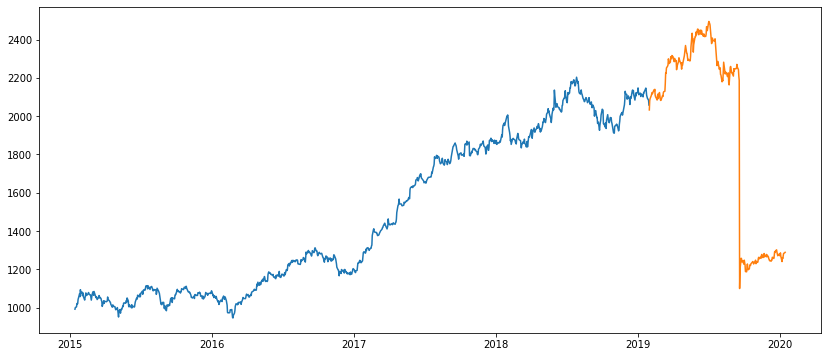

In [0]:
#for plotting
plt.figure(figsize=(14,6))
plt.plot(train)
plt.plot(test)
#closing_price = closing_price.astype('float64')
#plt.plot(closing_price)